# Algoritmo para rodar em tempo real na Raspberry - COM BUFFER

Pois é... Da outra vez deu merda pq não da pra duas threads lerem o respeaker ao mesmo tempo, então a gnt perde a janela de sobreposição. Dessa vez eu vou usar um buffer.

In [1]:
import sys
import pyaudio
import numpy as np
import warnings
import threading
import matplotlib.pyplot as plt
from IPython.display import Audio
from random import randint
from time import time, sleep

sys.path.append("/home/pi/Programming/IC2019/Raspberry/Python/")

from delayAndSum import delayAndSum as DaS
from extracaoFeatures import extrairFeaturesUnicoFrame as ExtrairFeatures
from iniciarNormalizadorEClassificador import main as IniciarObjetos

warnings.filterwarnings("ignore")

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Verificando o dispositivo que vamos usar pra gravar

In [2]:
def listarDispositivos():
    p = pyaudio.PyAudio()
    info = p.get_host_api_info_by_index(0)
    numdevices = info.get('deviceCount')

    for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

In [3]:
listarDispositivos()

Input Device id  0  -  seeed-4mic-voicecard: bcm2835-i2s-ac10x-codec0 ac10x-codec.1-003b-0 (hw:1,0)
Input Device id  3  -  ac108
Input Device id  5  -  default


### Definição de funções

In [4]:
def processarJanelaCompleta(idJanela, metadeInicialJanelaAtual, metadeFinalJanelaAtual):
    
    stringID = "(id:" + str(idJanela) + ")"
    inicioProcessamento = time()
    dictGlobal[str(idJanela)]["inicioProcessamento"] = inicioProcessamento
    print(stringID, "Iniciando o processamento. Timestamp:", inicioProcessamento)    
    
    # COPIANDO OS ARRAYS NA MEMORIA PRA GARANTIR QUE NAO VAI DAR BOSTA
    metadeInicial = np.copy(metadeInicialJanelaAtual)
    metadeFinal   = np.copy(metadeFinalJanelaAtual)
    
    # CONVERTO A JANELA PRA INT 16
    janelaInt16_A = np.fromstring(metadeInicial, dtype=np.int16)
    janelaInt16_B = np.fromstring(metadeFinal, dtype=np.int16)
    
    # COMO TEM OS 4 MICS NA JANELA, VOU DAR UM RESHAPE PRA CADA MIC FICAR EM UMA LINHA
    janelaInt16_A = janelaInt16_A.reshape((metadeTamanhoJanela, qtdCanais)).T   
    janelaInt16_B = janelaInt16_B.reshape((metadeTamanhoJanela, qtdCanais)).T
    
    # DELAY AND SUM
    sinalDaS_A = DaS(janelaInt16_A)
    sinalDaS_B = DaS(janelaInt16_B)
    
    # JUNTO AS METADES
    janelaCompleta = np.concatenate((sinalDaS_A, sinalDaS_B))
    
    # EXTRACAO DE FEATURES
    features = ExtrairFeatures(janelaCompleta, freqAmostragem)

    # NORMALIZANDO AS FEATURES
    features = objNormalizador.transform([features])[0]

    # CLASSIFICACAO
    predicao = objClassificador.predict([features])[0]
    
    fimProcessamento = time()
    dictGlobal[str(idJanela)]["fimProcessamento"] = fimProcessamento
    print(stringID, "Classificado como", predicao)
    print(stringID, "Processamento finalizado. Timestamp:", fimProcessamento)

### Rodando

In [5]:
idDispositivoGravacao = 0
tempoJanela           = 0.200
freqAmostragem        = 16000
profundidadeBytes     = 2
qtdCanais             = 4
metadeTamanhoJanela   = int((tempoJanela * freqAmostragem)/2)
caminhoCSVDataset     = "/home/pi/Datasets/SESA_v2_16kHz_16bits_200ms_58features_desescalonado_remocaoSilencio.csv"

In [6]:
objClassificador, objNormalizador = IniciarObjetos(caminhoCSVDataset, classificador=None, verbose=True)

Carregando o CSV do dataset
CSV carregado
Separando o que é data e target
Iniciando objeto normalizador
Treinando objeto normalizador
Normalizando os dados de treinamento
Instanciando objeto classificador
Treinando o classificador
objClassificador e objNormalizador prontos: operação finalizada.


### Com pausa

In [27]:
# LOOP
dictGlobal = {}
idJanela = 1
tempoReferencia = time()
while idJanela < 100:
    
    # INICIANDO O PYAUDIO E STREAM
    objPyAudio = pyaudio.PyAudio()
    stream = objPyAudio.open(
        input_device_index = idDispositivoGravacao,
        rate               = freqAmostragem,
        format             = objPyAudio.get_format_from_width(profundidadeBytes),
        channels           = qtdCanais,
        input              = True
    )

    # GRAVANDO
    janelasParciais = []
    for i in range(5):
        
        if i == 0:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(stream.read(metadeTamanhoJanela))
            
            idJanela += 1
            
        elif i == 1:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(stream.read(metadeTamanhoJanela))
            dictGlobal[str(idJanela-1)]["fimGravacao"] = time()
            
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela-1, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()
            
            idJanela += 1
            
        elif i == 2:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(stream.read(metadeTamanhoJanela))
            dictGlobal[str(idJanela-1)]["fimGravacao"] = time()
            
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela-1, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()
            
            idJanela += 1
            
        elif i == 3:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(stream.read(metadeTamanhoJanela))
            dictGlobal[str(idJanela-1)]["fimGravacao"] = time()
            
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela-1, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()
            
        else:
            janelasParciais.append(stream.read(metadeTamanhoJanela))
            dictGlobal[str(idJanela)]["fimGravacao"] = time()
            
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()
            
            idJanela += 1

    # PARANDO O AMBIENTE
    stream.stop_stream()
    stream.close()
    objPyAudio.terminate()
    del objPyAudio
    del stream

(id:1) Iniciando o processamento. Timestamp: 1595001481.1798997
(id:2) Iniciando o processamento. Timestamp: 1595001481.2444
(id:3) Iniciando o processamento. Timestamp: 1595001481.37226
(id:1) Classificado como siren
(id:1) Processamento finalizado. Timestamp: 1595001481.394789
(id:4) Iniciando o processamento. Timestamp: 1595001481.4366088
(id:2) Classificado como gunshot
(id:2) Processamento finalizado. Timestamp: 1595001481.5275655
(id:5) Iniciando o processamento. Timestamp: 1595001481.7054985
(id:3) Classificado como gunshot
(id:3) Processamento finalizado. Timestamp: 1595001481.727043
(id:4) Classificado como gunshot
(id:4) Processamento finalizado. Timestamp: 1595001481.7436395
(id:6) Iniciando o processamento. Timestamp: 1595001481.7701046
(id:7) Iniciando o processamento. Timestamp: 1595001481.8973649
(id:8) Iniciando o processamento. Timestamp: 1595001481.9625585
(id:5) Classificado como siren
(id:5) Processamento finalizado. Timestamp: 1595001482.0050952
(id:6) Classificado

(id:55) Iniciando o processamento. Timestamp: 1595001488.2138245
(id:53) Classificado como siren
(id:53) Processamento finalizado. Timestamp: 1595001488.2306983
(id:56) Iniciando o processamento. Timestamp: 1595001488.2776117
(id:54) Classificado como gunshot
(id:54) Processamento finalizado. Timestamp: 1595001488.343745
(id:55) Classificado como gunshot
(id:55) Processamento finalizado. Timestamp: 1595001488.5049622
(id:56) Classificado como gunshot
(id:56) Processamento finalizado. Timestamp: 1595001488.528733
(id:57) Iniciando o processamento. Timestamp: 1595001488.5452263
(id:58) Iniciando o processamento. Timestamp: 1595001488.6097975
(id:57)(id:59) Iniciando o processamento. Timestamp:  Classificado como siren
(id:57) Processamento finalizado. Timestamp: 1595001488.747943
1595001488.7482336
(id:60) Iniciando o processamento. Timestamp: 1595001488.8029559
(id:58) Classificado como gunshot
(id:58) Processamento finalizado. Timestamp: 1595001488.8539593
(id:59) Classificado como gun

In [13]:
stream.stop_stream()
stream.close()
objPyAudio.terminate()
del objPyAudio
del stream

### Com flip

In [40]:
# # INICIANDO O PYAUDIO E STREAM
# objPyAudio = pyaudio.PyAudio()
# stream = objPyAudio.open(
#     input_device_index = idDispositivoGravacao,
#     rate               = freqAmostragem,
#     format             = objPyAudio.get_format_from_width(profundidadeBytes),
#     channels           = qtdCanais,
#     input              = True
# )

# # LOOP
# dictGlobal = {}
# j = 1
# janelas = [stream.read(metadeTamanhoJanela), stream.read(metadeTamanhoJanela)]
# tempoReferencia = time()
# while j < 20:

#     # GRAVANDO
#     dictGlobal[str(j)] = {"inicioGravacao": time()}
    
#     # SE A ITERACAO ATUAL FOR IMPAR, EU GRAVO NO INICIO
#     if j%2 != 0:
#         janelas[0] = stream.read(metadeTamanhoJanela)
        
#         # E A ORDEM EH A QUE TINHA SIDO GRAVADA ANTES [1], COM A QUE FOI GRAVADA AGR [0]
#         objThread = threading.Thread(target=processarJanelaCompleta, args=(j, janelas[1], janelas[0]))
#         objThread.start()
    
#     # SE A ITERACAO ATUAL FOR PAR, EU GRAVO NO FINAL
#     else:
#         janelas[1] = stream.read(metadeTamanhoJanela)
        
#         # A ORDEM AGR MUDA. O QUE FOI GRAVADO ANTES TA NA POSICAO 0
#         objThread = threading.Thread(target=processarJanelaCompleta, args=(j, janelas[0], janelas[1]))
#         objThread.start()
        
#     j += 1

# # PARANDO O AMBIENTE
# stream.stop_stream()
# stream.close()
# objPyAudio.terminate()
# del objPyAudio
# del stream

### Printando

In [15]:
def corAleatoria():
    return "#" + str(randint(10,99)) + str(randint(10,99)) + str(randint(10,99))

In [31]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [40, 25], 
    'axes.labelsize': 14,
    'axes.titlesize':18, 
    'font.size': 18,
    'legend.fontsize': 12, 
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

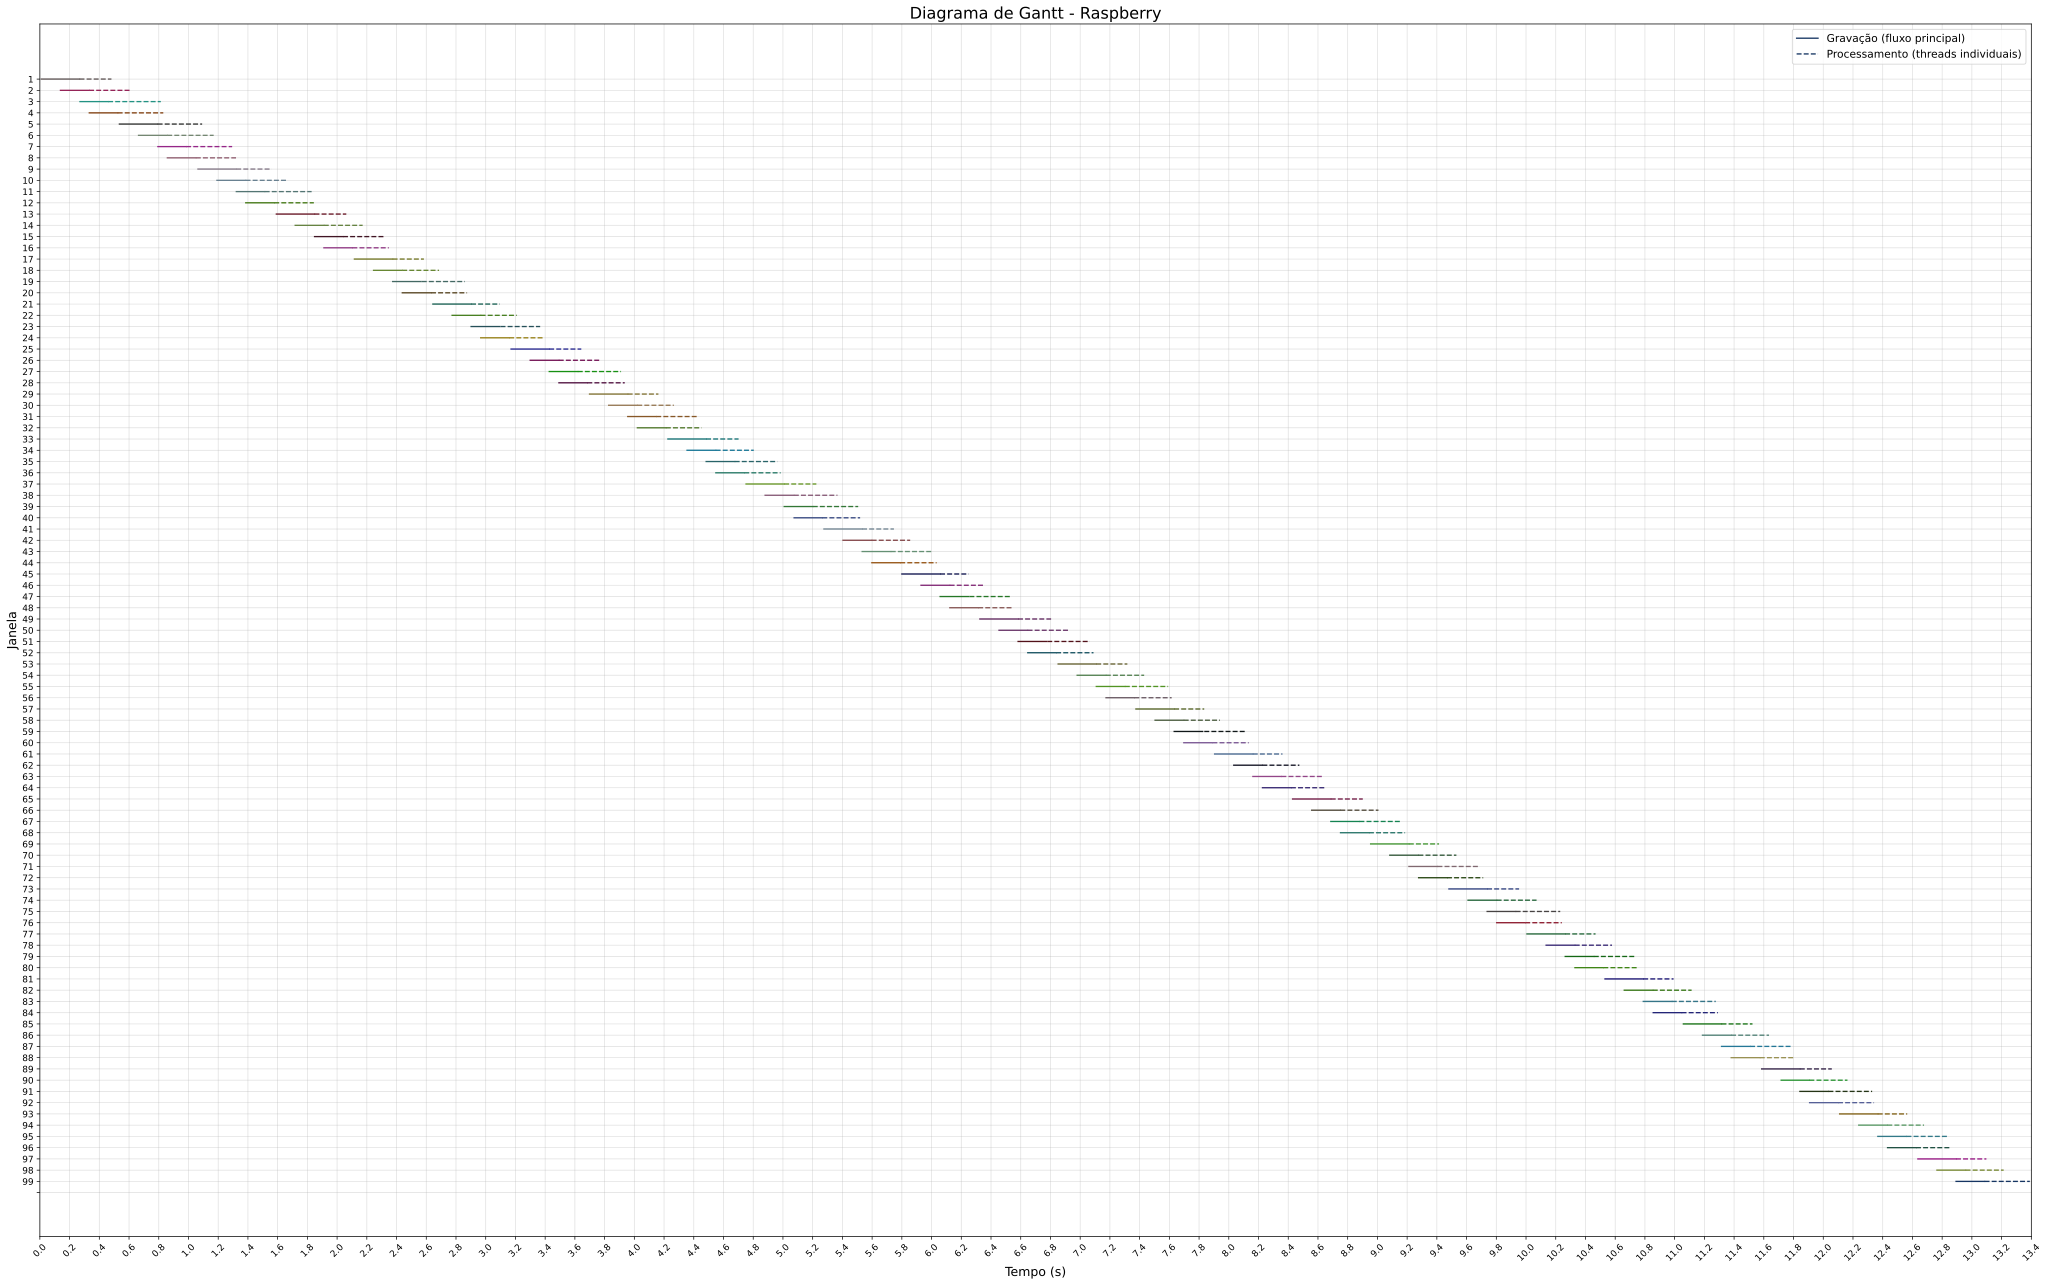

In [39]:
caminhoSalvar = "/home/pi/Programming/IC2019/Raspberry/Resultados/"
yTicks = []

for i, chave in enumerate(dictGlobal):
    
    if i == len(dictGlobal)-1:
        continue
    
    # AJUSTANDO O EIXO X DA ITERACAO ATUAL
    inicioGravacao      = dictGlobal[chave]["inicioGravacao"] - tempoReferencia
    fimGravacao         = dictGlobal[chave]["fimGravacao"] - tempoReferencia
    inicioProcessamento = dictGlobal[chave]["inicioProcessamento"] - tempoReferencia
    fimProcessamento    = dictGlobal[chave]["fimProcessamento"] - tempoReferencia
    
    # DEFININDO A COR
    corAtual = corAleatoria()
    
    # COLOCANDO A ITERACAO ATUAL NO YTICKS
    yTicks.append(chave)
    
    # PLOTANDO
    plt.plot([inicioGravacao, fimGravacao], [i, i], "-", color=corAtual)
    plt.plot([inicioProcessamento, fimProcessamento], [i, i], "--", color=corAtual)

# CRIANDO A LEGENDA
plt.plot([fimProcessamento,fimProcessamento],[i-1,i-1], "-", label="Gravação (fluxo principal)", color=corAtual)
plt.plot([fimProcessamento,fimProcessamento],[i-1,i-1], "--", label="Processamento (threads individuais)", color=corAtual)

# AJUSTANDO MAIS PARAMETROS
plt.title("Diagrama de Gantt - Raspberry")
plt.ylabel("Janela")
plt.xlabel("Tempo (s)")
plt.legend()
plt.xlim(0, fimProcessamento)
plt.xticks(ticks=np.arange(0, fimProcessamento+tempoJanela, tempoJanela), rotation=45)
plt.yticks(ticks=np.arange(0, i+1), labels=yTicks)
plt.gca().invert_yaxis()
plt.grid(alpha=0.4)
plt.savefig(caminhoSalvar+"diagramaGantt_raspberry.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [25]:
dictGlobal

{'1': {'inicioGravacao': 1595001349.704442,
  'fimGravacao': 1595001349.9609632,
  'inicioProcessamento': 1595001349.9614666,
  'fimProcessamento': 1595001350.173251},
 '2': {'inicioGravacao': 1595001349.8332253,
  'fimGravacao': 1595001350.0254812,
  'inicioProcessamento': 1595001350.0261362,
  'fimProcessamento': 1595001350.283722},
 '3': {'inicioGravacao': 1595001349.9620087,
  'fimGravacao': 1595001350.1534054,
  'inicioProcessamento': 1595001350.1541352,
  'fimProcessamento': 1595001350.514243},
 '4': {'inicioGravacao': 1595001350.0272279,
  'fimGravacao': 1595001350.2175102,
  'inicioProcessamento': 1595001350.2187865,
  'fimProcessamento': 1595001350.5306647},
 '5': {'inicioGravacao': 1595001350.2299194,
  'fimGravacao': 1595001350.4866033,
  'inicioProcessamento': 1595001350.4876354,
  'fimProcessamento': 1595001350.800565},
 '6': {'inicioGravacao': 1595001350.3588154,
  'fimGravacao': 1595001350.550757,
  'inicioProcessamento': 1595001350.5513039,
  'fimProcessamento': 1595001